Secret Manager Function

In [34]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

Connect to Database

In [35]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

Question 1

In [51]:
import pandas as pd

sql = """
SELECT 
    year,
    pop,
    ROUND(
        (pop - LAG(pop) OVER (ORDER BY year)) * 100.0
        / LAG(pop) OVER (ORDER BY year),
        2
    ) AS growth_rate
FROM population
WHERE fips = '32'
ORDER BY year;
"""

df = pd.read_sql(sql, conn)  # conn = your psycopg2 connection
print(df.head())

   year      pop  growth_rate
0  2005  2381281          NaN
1  2006  2495529         4.80
2  2007  2565382         2.80
3  2008  2600167         1.36
4  2009  2643085         1.65


In [52]:
! pip install jupyter-ai-magics[all] -q
import warnings
warnings.simplefilter('ignore')
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']
%load_ext jupyter_ai_magics

The jupyter_ai_magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_ai_magics


In [53]:
%%ai gpt4 -f code
Create a line chart in Python using the avilable df{df}:Chart must include the state name in the title and the growth rate.

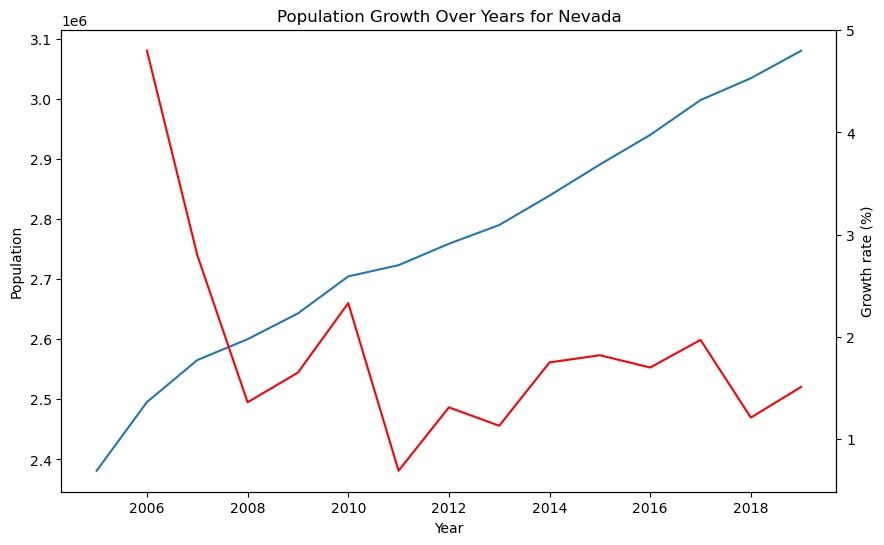

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df['year'], df['pop'])
ax.set_xlabel('Year')
ax.set_ylabel('Population')

ax2 = ax.twinx()
ax2.plot(df['year'], df['growth_rate'], color='red')
ax2.set_ylabel('Growth rate (%)')

plt.title('Population Growth Over Years for Nevada')
plt.show()

Question 1: The graph illustrates a sharp decline in Nevada’s population growth rate from nearly 5% in 2006 to around 1.5% by 2008. After a brief increase in 2010, growth dropped again in 2011 to just above 0.5%. Since 2012, the rate stabilized between 1% and 2%, suggesting a steadier pattern of growth.
Changes Made to AI Code: I changed the SQL part of the code, because the table was named "name" instead of "state" and there is no name column in the population table, so I found the fips of Nevada and subsituted that as well. 

Question 2

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

sql = """
SELECT 
    p.year,
    p.pop,
    i.income AS median_income
FROM population p
JOIN income i
    ON p.fips = i.fips AND p.year = i.year
WHERE p.fips = '32'
ORDER BY p.year;
"""

q2df = pd.read_sql(sql, conn)
print(q2df.head())

   year      pop  median_income
0  2005  2381281          49169
1  2006  2495529          52998
2  2007  2565382          55062
3  2008  2600167          56361
4  2009  2643085          53341


In [46]:
%%ai gpt4 -f code
Create a dual-axis chart in Python using the avilable df{q2df}:X-axis = year,Left Y-axis = population (line), Right Y-axis = median household income (bar or line, different color), Chart must include the state name in the title.

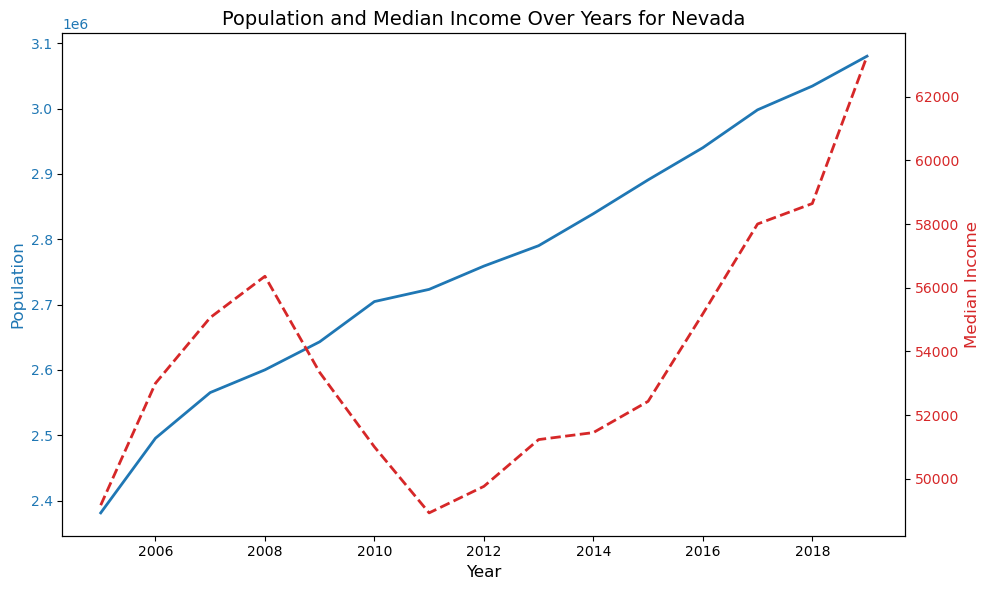

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

df_to_plot = q2df

fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Population', color=color, fontsize=12)
ax1.plot(df_to_plot['year'], df_to_plot['pop'], color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Median Income', color=color, fontsize=12) 
ax2.plot(df_to_plot['year'], df_to_plot['median_income'], color=color, linewidth=2, linestyle='--') 
ax2.tick_params(axis='y', labelcolor=color)

state_name = "Nevada" 
if 'name' in df_to_plot.columns and not df_to_plot.empty:
    state_name = df_to_plot['name'].iloc[0]

plt.title(f'Population and Median Income Over Years for {state_name}', fontsize=14)
fig.tight_layout()  
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.show()


Question 2: From 2004 to 2019, Nevada experienced steady population growth, starting at 2.4 million and ending at over 3.1 million. In contrast, median household income was more unsteady. It rose until 2007, dipped through 2008-2012, and then recovered after 2012. Changes to AI Code: I had to change the dataframe names and change state_name to name.

Question 3

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

sql_query = """
WITH RollingAvg AS (
    SELECT 
        fips,
        year,
        AVG(pop) OVER (
            ORDER BY year 
            ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING
        ) AS rolling_avg_pop
    FROM 
        population
    WHERE 
        fips = '32'
)
SELECT 
    RA.year,
    P.name AS state_name, 
    ROUND(
        (RA.rolling_avg_pop - LAG(RA.rolling_avg_pop, 1) OVER (ORDER BY RA.year)), 
        0
    ) AS smoothed_pop_change
FROM 
    RollingAvg RA
JOIN 
    name P ON RA.fips = P.fips
ORDER BY 
    RA.year;
"""

avgchangedf = pd.read_sql(sql_query, conn)
print(avgchangedf.head())

   year state_name  smoothed_pop_change
0  2005     Nevada                  NaN
1  2006     Nevada              42326.0
2  2007     Nevada              72962.0
3  2008     Nevada              49185.0
4  2009     Nevada              46420.0


In [27]:
%%ai gpt4 -f code
Use data in {avgchangedf} to create a bar chart which includes the state name at the top of the graph to show the trend of average growth. 

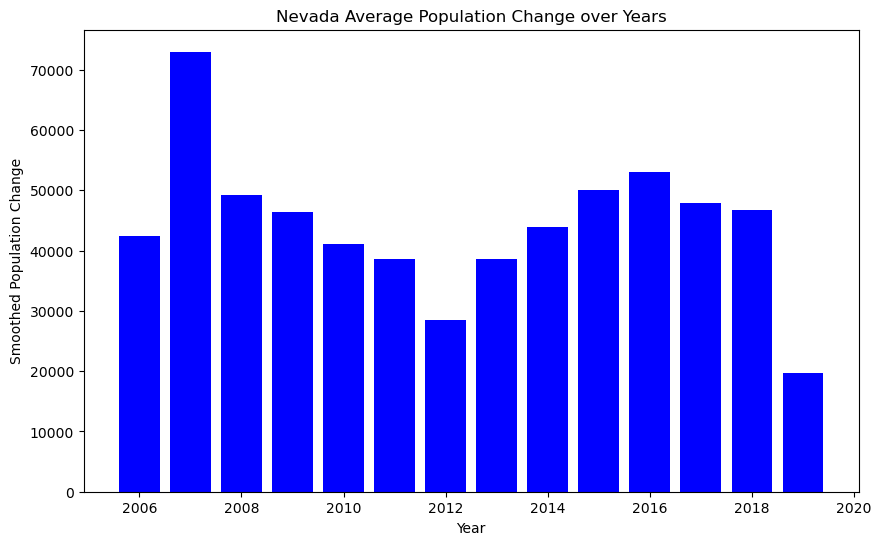

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(avgchangedf['year'], avgchangedf['smoothed_pop_change'], color='blue')
plt.title(avgchangedf.iloc[0]['state_name'] + ' Average Population Change over Years')
plt.xlabel('Year')
plt.ylabel('Smoothed Population Change')
plt.show()

Question 3: Based on the chart, the plot visually tracks the state's average population tend, defined as the year-over-year change in the 3-year rolling average population. The chart highlights that population growth was positive over this period, but the rate of acceleration was changing often. Momentum peaked in 2007 (about 72,000). Following this peak, there was a period of deceleration, bottoming out in 2012 (about 28,000), which shows the rate of growth slowed. The average change then recovered, reaching a smaller peak in 2016 (about 53,000) before ending the period with a final, sharp drop to the lowest point on the graph in 2019 (about 20,000). I did not have to change the AI generate code. 